/home/cauman/work/image-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
Loading weights: 100%|█████████████| 1468/1468 [00:01<00:00, 947.47it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]
/home/cauman/work/image-research/.venv/lib/python3.13/site-packages/transformers/integrations/sdpa_attention.py:92: UserWarning: Flash Efficient attention on Current AMD GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/cauman/work/image-research/.venv/lib/python3.13/site-packages/transformers/integrations/sdpa_attention.py

Found 1 objects


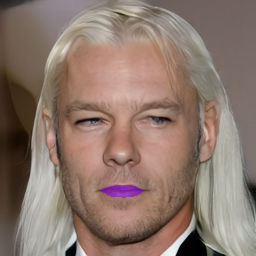

In [1]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

image_url = "../images/20.png"
image = Image.open(image_url).convert("RGB")
inputs = processor(images=image, text="mouth", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")

import numpy as np
import matplotlib

def overlay_masks(image, masks):
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask, color in zip(masks, colors):
        mask = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image
overlay_masks(image, results["masks"])








In [2]:
from pathlib import Path

import torch
import numpy as np
import matplotlib
from PIL import Image

from transformers import Sam3Processor, Sam3Model

# ----------------------------
# Config
# ----------------------------
IMAGES_DIR = Path("../images")
OUT_HAIR = Path("grid_hair_overlay.png")
OUT_MOUTH = Path("grid_mouth_overlay.png")

ROWS = 5
COLS = 5
PADDING = 8  # pixels between tiles

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Load model + processor
# ----------------------------
model = Sam3Model.from_pretrained("facebook/sam3").to(device).eval()
processor = Sam3Processor.from_pretrained("facebook/sam3")

# ----------------------------
# Mask overlay helper
# ----------------------------
def overlay_masks(image_rgb: Image.Image, masks: torch.Tensor, alpha_scale: float = 0.5) -> Image.Image:
    """
    image_rgb: PIL RGB
    masks: Tensor [N, H, W] (bool/0-1/float) on GPU/CPU
    """
    image = image_rgb.convert("RGBA")

    if masks is None or len(masks) == 0:
        return image

    masks_u8 = (255 * masks.detach().float().cpu().numpy()).astype(np.uint8)  # [N,H,W]
    n_masks = masks_u8.shape[0]

    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(max(n_masks, 1))
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(n_masks)]

    for mask_u8, color in zip(masks_u8, colors):
        mask_img = Image.fromarray(mask_u8, mode="L")
        overlay = Image.new("RGBA", image.size, color + (0,))
        # Convert mask (0..255) -> alpha (0..~127 if alpha_scale=0.5)
        alpha = mask_img.point(lambda v: int(v * alpha_scale))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)

    return image

# ----------------------------
# SAM3 run helper
# ----------------------------
@torch.no_grad()
def segment_and_overlay(img: Image.Image, prompt: str, threshold: float = 0.5, mask_threshold: float = 0.5) -> Image.Image:
    inputs = processor(images=img, text=prompt, return_tensors="pt")
    inputs = {k: v.to(device) if hasattr(v, "to") else v for k, v in inputs.items()}

    outputs = model(**inputs)

    results = processor.post_process_instance_segmentation(
        outputs,
        threshold=threshold,
        mask_threshold=mask_threshold,
        target_sizes=inputs["original_sizes"].tolist(),
    )[0]

    masks = results.get("masks", None)
    return overlay_masks(img, masks)

# ----------------------------
# Grid builder
# ----------------------------
def make_grid(images_rgba, rows: int, cols: int, padding: int = 0) -> Image.Image:
    assert len(images_rgba) == rows * cols, f"Expected {rows*cols} images, got {len(images_rgba)}"

    # Ensure all same size by resizing to first image size
    w0, h0 = images_rgba[0].size
    tiles = []
    for im in images_rgba:
        if im.size != (w0, h0):
            im = im.resize((w0, h0), resample=Image.BILINEAR)
        tiles.append(im)

    grid_w = cols * w0 + (cols - 1) * padding
    grid_h = rows * h0 + (rows - 1) * padding
    canvas = Image.new("RGBA", (grid_w, grid_h), (0, 0, 0, 0))

    for idx, im in enumerate(tiles):
        r = idx // cols
        c = idx % cols
        x = c * (w0 + padding)
        y = r * (h0 + padding)
        canvas.paste(im, (x, y), im)

    return canvas

# ----------------------------
# Load images 0..24 numerically
# ----------------------------
paths = [IMAGES_DIR / f"{i}.png" for i in range(ROWS * COLS)]
missing = [str(p) for p in paths if not p.exists()]
if missing:
    raise FileNotFoundError(f"Missing images: {missing}")

imgs_rgb = [Image.open(p).convert("RGB") for p in paths]

# ----------------------------
# Build hair overlay set + mouth overlay set
# ----------------------------
hair_overlays = []
mouth_overlays = []

for i, img in enumerate(imgs_rgb):
    hair_overlays.append(segment_and_overlay(img, prompt="hair"))
    mouth_overlays.append(segment_and_overlay(img, prompt="mouth"))
    print(f"Processed {i+1}/{len(imgs_rgb)}")

# ----------------------------
# Assemble 5x5 grids and save
# ----------------------------
grid_hair = make_grid(hair_overlays, rows=ROWS, cols=COLS, padding=PADDING)
grid_mouth = make_grid(mouth_overlays, rows=ROWS, cols=COLS, padding=PADDING)

grid_hair.save(OUT_HAIR)
grid_mouth.save(OUT_MOUTH)

print(f"Saved: {OUT_HAIR.resolve()}")
print(f"Saved: {OUT_MOUTH.resolve()}")


Loading weights: 100%|█████████████| 1468/1468 [00:01<00:00, 936.22it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]


Processed 1/25
Processed 2/25
Processed 3/25
Processed 4/25
Processed 5/25
Processed 6/25
Processed 7/25
Processed 8/25
Processed 9/25
Processed 10/25
Processed 11/25
Processed 12/25
Processed 13/25
Processed 14/25
Processed 15/25
Processed 16/25
Processed 17/25
Processed 18/25
Processed 19/25
Processed 20/25
Processed 21/25
Processed 22/25
Processed 23/25
Processed 24/25
Processed 25/25
Saved: /home/cauman/work/image-research/src/grid_hair_overlay.png
Saved: /home/cauman/work/image-research/src/grid_mouth_overlay.png
